# Sequential Domain Reduction

## Background
Sequential domain reduction is a process where the bounds of the optimization problem are mutated (typically contracted) to reduce the time required to converge to an optimal value. The advantage of this method is typically seen when a cost function is particularly expensive to calculate, or if the optimization routine oscilates heavily. 

## Basics

The basic steps are a *pan* and a *zoom*. These two steps are applied at one time, therefore updating the problem search space evey iteration.

**Pan**: recentering the region of interest around the most optimal point found.

**Zoom**: contract the region of interest.

![](sdr.png)


## Parameters

There are three parameters for the built-in `SequentialDomainReductionTransformer` object:


$\gamma_{osc}:$ shrinkage  parameter  for  oscillation. Typically [0.5-0.7]. Default = 0.7

$\gamma_{pan}:$ panning parameter. Typically 1.0. Default = 1.0

$\eta:$ zoom parameter. Default = 0.9


More information can be found in this reference document:

---

Title: "On the robustness of a simple domain reduction scheme for simulation‐based optimization" 

Date: 2002 

Author: Stander, N. and Craig, K. 


---
---
Let's start by importing the packages we'll be needing

In [1]:
import numpy as np
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
import matplotlib.pyplot as plt

Now let's create an example cost function. This is the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function), which is quite non-linear. 

In [2]:
def ackley(**kwargs):
    x = np.fromiter(kwargs.values(), dtype=float)
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    return -1.0 * (-20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e)

We will use the standard bounds for this problem.

In [3]:

pbounds = {'x': (-5, 5), 'y': (-5, 5)}




This is where we define our `bound_transformer` , the Sequential Domain Reduction Transformer



In [17]:
bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)

Now we can set up two idential optimization problems, except one has the `bound_transformer` variable set.

In [18]:
mutating_optimizer = BayesianOptimization(
    f=ackley,
    pbounds=pbounds,
    verbose=0,
    random_state=1,
    bounds_transformer=bounds_transformer
)

In [19]:
mutating_optimizer.maximize(
    init_points=2,
    n_iter=50,
)

In [20]:
standard_optimizer = BayesianOptimization(
    f=ackley,
    pbounds=pbounds,
    verbose=0,
    random_state=1,
)

In [21]:
standard_optimizer.maximize(
    init_points=2,
    n_iter=50,
)

After both have completed we can plot to see how the objectives performed. It's quite obvious to see that the Sequential Domain Reduction technique contracted onto the optimal point relativly quickly.

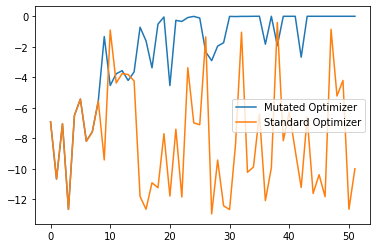

In [22]:
plt.plot(mutating_optimizer.space.target, label='Mutated Optimizer')
plt.plot(standard_optimizer.space.target, label='Standard Optimizer')
plt.legend()

Now let's plot the actual contraction of one of the variables (`x`)

In [23]:
# example x-bound shrinking - we need to shift the x-axis by the init_points as the bounds
# transformer only mutates when searching - not in the initial phase.
x_min_bound = [b[0][0] for b in bounds_transformer.bounds]
x_max_bound = [b[0][1] for b in bounds_transformer.bounds]
x = [x[0] for x in mutating_optimizer.space.params]
bounds_transformers_iteration = list(range(2, len(x)))

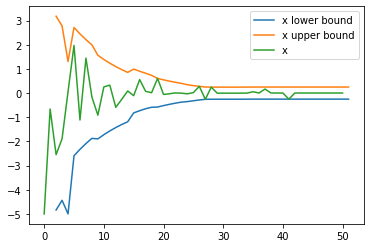

In [24]:
plt.plot(bounds_transformers_iteration, x_min_bound[1:], label='x lower bound')
plt.plot(bounds_transformers_iteration, x_max_bound[1:], label='x upper bound')
plt.plot(x[1:], label='x')
plt.legend()
